In [1]:
# Import modules and packages
import numpy as np
import problemLibrary as pl
import os
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, execute

degree = 3 # degree of graph
rounds = 1 # number of rounds

# Load the fixed angles from angles_regular_graphs.json taken from https://github.com/danlkv/fixed-angle-QAOA
angle_data = pl.fixed_angles_data[str(degree)][str(rounds)]
betas = angle_data['beta']
gammas = angle_data['gamma']
guarantee = angle_data['AR']

In [2]:
def create_QAOA_circuit(nodes, edges, betas, gammas):
    assert len(betas) == len(gammas), "Betas and Gammas lists should be of the same length"
    rounds = len(betas)
    circuit = QuantumCircuit(nodes)
    for i in range(nodes):
        # Apply the Hadamard gate on each qubit
        circuit.h(i)

    for roundIndex in range(rounds):
        # For each round, apply RZZ gates followed by RX gates
        beta = betas[roundIndex]
        gamma = gammas[roundIndex]

        for i,j in edges:
            # exp(i gamma/2 Z_i Z_j)
            circuit.rzz(- gamma, nodes - i - 1, nodes - j - 1)
            # circuit.rzz( -gamma, i, j)
        for i in range(nodes):
            # exp(-i beta X_i)
            circuit.rx(2 * beta, i)
    
    return circuit


def get_QAOA_approxRatio(size, betas, gammas):
    """
    Obtain the approximation ratio using a state vector simulator, for a graph of given size (and degree 3; load from the problemLibrary), and with the given angles
    """
    # Load the problem
    nodes, edges = pl.read_maxcut_instance(size)
    optVal, solution = pl.read_maxcut_solution(size)
    # Create QAOA circuit
    circuit = create_QAOA_circuit(nodes, edges, betas, gammas)

    # Obtain probabilities using state vector simulation 
    sv = Aer.get_backend('statevector_simulator')
    sv_counts = execute(circuit, sv).result().get_counts()
    
    # Get energy expectation value
    energyExpectation = 0
    for (cut, count) in sv_counts.items():
        size = pl.eval_cut(nodes, edges, cut)
        energyExpectation = energyExpectation + size * count
    
    # Get approximation ratio
    approximationRatio = energyExpectation / optVal

    return approximationRatio    

In [3]:
size_list = list(range(4,17,2))
ar_list = [get_QAOA_approxRatio(size,betas, gammas) for size in size_list]

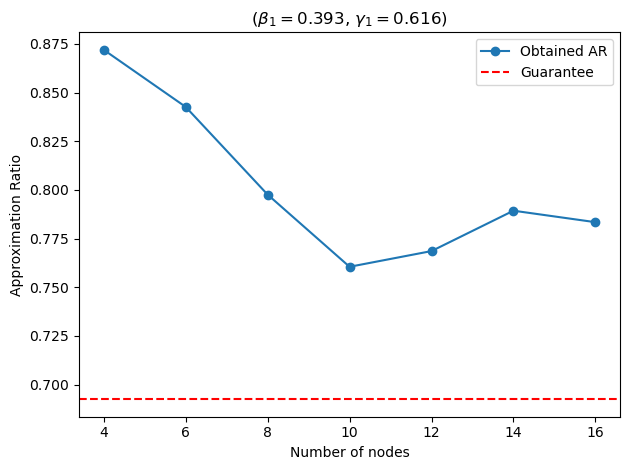

In [4]:
plt.plot(size_list, ar_list, '-o', label='Obtained AR')
plt.axhline(y=guarantee, ls='--', c='r', label='Guarantee')
angle_str = ""
for ind in range(rounds):
    angle_str += r"($\beta_{}={:.3f}$,".format(ind + 1, betas[ind])
    angle_str += r" $\gamma_{}={:.3f}$) ".format(ind + 1, gammas[ind]) + "\n"
angle_str = angle_str[:-2]
plt.title(angle_str)
plt.xlabel("Number of nodes")
plt.ylabel("Approximation Ratio")
plt.legend()
plt.tight_layout()
plt.savefig("Rounds={}.png".format(rounds), dpi=300)


# Parameter Sweep
Compute the approximation ratio using the state vector simulator for a range of values in the entire range for $\beta$ and $\gamma$ parameters (for rounds=1).

In [5]:
# Parameter sweep for a particular problem size
# betas lie in [0,pi]
# gammas lie in [0,2pi]
size = 4
numpts = 50
_betas = np.linspace(0, np.pi, numpts)
_gammas = np.linspace(0, 2 * np.pi, numpts)
betas_arr, gammas_arr = np.meshgrid(_betas, _gammas)
ar_arr = np.zeros(betas_arr.shape)
for indx in range(numpts):
    for indy in range(numpts):
        beta = [betas_arr[indx, indy]]
        gamma = [gammas_arr[indx, indy]]
        ar_arr[indx, indy] = get_QAOA_approxRatio(size, beta, gamma)
fixed_beta, fixed_gamma = pl.fixed_angles_data["3"]["1"]['beta'], pl.fixed_angles_data["3"]["1"]['gamma']
fixed_AR = get_QAOA_approxRatio(size, fixed_beta, fixed_gamma)

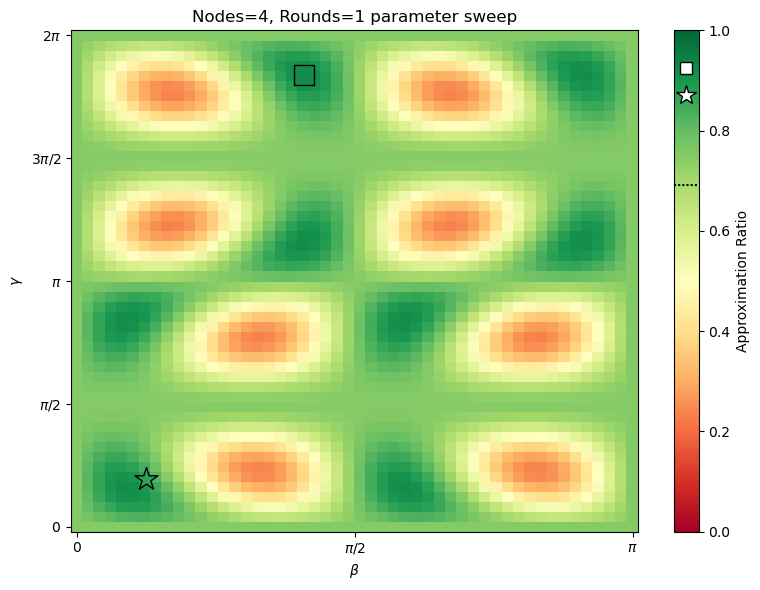

In [6]:
import matplotlib.cm as cm
cmap = cm.get_cmap('RdYlGn')
fig, ax = plt.subplots(figsize=(8,6))
# Colormap from the parameter sweep
cc = ax.pcolor(betas_arr, gammas_arr, ar_arr, vmin = 0, vmax = 1, cmap=cmap)
# Plot the AR obtained for the fixed angle parameters
ax.scatter(fixed_beta, fixed_gamma, c= [cmap(fixed_AR)], s=300, marker = '*', linewidths=1, edgecolors='k', label = "Fixed Angle")
# Plot the best obtained approximation ratio point
maxx, maxy = np.unravel_index(np.argmax(ar_arr), ar_arr.shape)
ax.scatter(betas_arr[maxx,maxy], gammas_arr[maxx,maxy], c= [cmap(ar_arr[maxx,maxy])], s=200, marker = 's', linewidths=1, edgecolors='k', label = "Best AR")
# Mark the AR's obtained at the fixed angles, the highest obtained AR, and the guarantee on the colorbar
guar = pl.fixed_angles_data["3"]["1"]['AR']
cbar = plt.colorbar(cc); cbar.set_label("Approximation Ratio")
cbar.ax.plot(0.5, fixed_AR, 'w*', mec='k', ms=15); cbar.ax.plot(0.5, ar_arr[maxx,maxy] , c='w', marker='s', mec='k', ms=8); cbar.ax.plot([0,1], [guar,guar] , c='k', ls=(0,(1,1)), mec='k')
# Labels, etc.
ax.set_title("Nodes={}, Rounds=1 parameter sweep".format(size))
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$\gamma$")
_ = ax.set_xticks([0, np.pi/2, np.pi], labels=["$0$", r"$\pi/2$", r'$\pi$'])
_ = ax.set_yticks([0, np.pi/2, np.pi, np.pi*1.5, np.pi *2], labels=["$0$", r"$\pi/2$", r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
plt.tight_layout()
plt.savefig("Sweep-Size={}-Rounds={}.png".format(size, 1), dpi=300)

Random restarts. Choose a few randomly chosen initial angles. Use the `COBYLA` optimizer for 30 iterations, and plot the trajectories on the landscape.

In [7]:
restarts = 5
rounds = 1
num_shots = 1000
max_iter = 30

def get_QAOA_approxRatio_qasm(size, betas, gammas, num_shots):
    """
    Obtain the approximation ratio using the qasm simulator, for a graph of given size (and degree 3; load from the problemLibrary), and with the given angles
    """
    # Load the problem
    nodes, edges = pl.read_maxcut_instance(size)
    optVal, solution = pl.read_maxcut_solution(size)
    # Create QAOA circuit
    circuit = create_QAOA_circuit(nodes, edges, betas, gammas)
    circuit.measure_all()
    # Obtain probabilities using state vector simulation 
    backend = Aer.get_backend('qasm_simulator')
    counts = backend.run(circuit, nshots=num_shots).result().get_counts()
    
    # Get energy expectation value
    energyExpectation = 0
    totalCounts = 0
    for (cut, count) in counts.items():
        size = pl.eval_cut(nodes, edges, cut)
        energyExpectation = energyExpectation + size * count
        totalCounts = totalCounts + count
    energyExpectation = energyExpectation / totalCounts
    return energyExpectation / optVal

from scipy.optimize import minimize
import numpy as np


# Generate random initial conditions
np.random.seed(1)
theta_min = [0] * 2 * rounds
theta_max = [np.pi] * rounds + [2 * np.pi] * rounds # Upper limit for betas=pi; upper limit for gammas=2pi
thetas = np.random.uniform(low=theta_min, high=theta_max, size=(restarts,2 * rounds))

angles_evolution = [None] * restarts
temp_list = []
for restartInd in range(restarts):
    init_thetas = thetas[restartInd, :].tolist()
    temp_list = [init_thetas]
    def toOptimizeFunc(angles):
        rounds = len(angles) // 2
        betas = init_thetas[:rounds]
        gammas = init_thetas[rounds:]
        return -get_QAOA_approxRatio_qasm(size, betas, gammas, num_shots)
    
    def store_angles(angles):
        temp_list.append(angles.tolist())
    
    res = minimize(toOptimizeFunc, init_thetas, method='COBYLA', callback = store_angles, options = { 'maxiter': max_iter})
    angles_evolution[restartInd] = temp_list

Plot the landscape of the approximation ratio

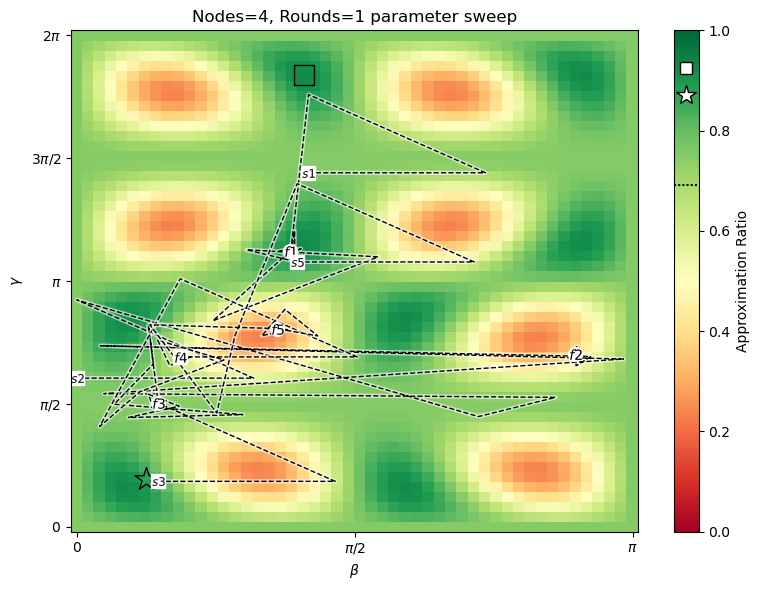

In [8]:
import matplotlib.cm as cm
cmap = cm.get_cmap('RdYlGn')
fig, ax = plt.subplots(figsize=(8,6))
# Colormap from the parameter sweep
cc = ax.pcolor(betas_arr, gammas_arr, ar_arr, vmin = 0, vmax = 1, cmap=cmap)
# Plot the AR obtained for the fixed angle parameters
ax.scatter(fixed_beta, fixed_gamma, c= [cmap(fixed_AR)], s=300, marker = '*', linewidths=1, edgecolors='k', label = "Fixed Angle")
# Plot the best obtained approximation ratio point
maxx, maxy = np.unravel_index(np.argmax(ar_arr), ar_arr.shape)
ax.scatter(betas_arr[maxx,maxy], gammas_arr[maxx,maxy], c= [cmap(ar_arr[maxx,maxy])], s=200, marker = 's', linewidths=1, edgecolors='k', label = "Best AR")
# Mark the AR's obtained at the fixed angles, the highest obtained AR, and the guarantee on the colorbar
guar = pl.fixed_angles_data["3"]["1"]['AR']
cbar = plt.colorbar(cc); cbar.set_label("Approximation Ratio")
cbar.ax.plot(0.5, fixed_AR, 'w*', mec='k', ms=15); cbar.ax.plot(0.5, ar_arr[maxx,maxy] , c='w', marker='s', mec='k', ms=8); cbar.ax.plot([0,1], [guar,guar] , c='k', ls=(0,(1,1)), mec='k')
# Labels, etc.
ax.set_title("Nodes={}, Rounds=1 parameter sweep".format(size))
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$\gamma$")
ax.set_xticks([0, np.pi/2, np.pi], labels=["$0$", r"$\pi/2$", r'$\pi$'])
ax.set_yticks([0, np.pi/2, np.pi, np.pi*1.5, np.pi *2], labels=["$0$", r"$\pi/2$", r'$\pi$', r'$3\pi/2$', r'$2\pi$'])

# Plot also the restart angles and trajectories
# colors = cm.turbo(np.linspace(0.1,0.5,restarts))
for restartInd in range(restarts):
    # Plot trajectories
    angles = angles_evolution[restartInd]; betas = [a[0] % np.pi for a in angles]; gammas = [a[1] % (2 * np.pi) for a in angles]
    ax.plot(betas,gammas, '-', c = 'w', lw=3, alpha=0.6); ax.plot(betas,gammas, '--', c = 'k', lw=1)
for restartInd in range(restarts):
    # Plot start and end points
    angles = angles_evolution[restartInd]; betas = [a[0] % np.pi for a in angles]; gammas = [a[1] % (2 * np.pi) for a in angles]
    ax.plot(betas[0], gammas[0], 's', mfc='w', mec='w', markersize=10); ax.plot(betas[0], gammas[0], marker='$s{}$'.format(restartInd+1), color='k', markersize=9, lw=0, mec='None') #starting point
    ax.plot(betas[-1], gammas[-1], 'o', mfc='w', mec = 'w', markersize=10) ; ax.plot(betas[-1], gammas[-1], marker='$f{}$'.format(restartInd+1), mfc='k', markersize=9, lw=0, mec='None') #end point

plt.tight_layout()
plt.savefig("RestartSweep-Size={}-Rounds={}.png".format(size, 1), dpi=300)
